# Reading raster files with Rasterio

[Rasterio](https://mapbox.github.io/rasterio/) is a highly useful module for raster processing which you can use for reading and writing [several different raster formats](http://www.gdal.org/formats_list.html) in Python. Rasterio is based on [GDAL](http://www.gdal.org/) and Python automatically registers all known GDAL drivers for reading supported
formats when importing the module. Most common file formats include for example [TIFF and GeoTIFF](http://www.gdal.org/frmt_gtiff.html),
[ASCII Grid](http://www.gdal.org/frmt_various.html#AAIGrid) and [Erdas Imagine .img](http://www.gdal.org/frmt_hfa.html) -files.


In [1]:
import rasterio
import os
import numpy as np
%matplotlib inline

# Data dir
data_dir = "data/raster"
fp = os.path.join(data_dir, "satelite_torino.tif")

# Open the file:
raster = rasterio.open(fp)

# Check type of the variable 'raster'
type(raster)

rasterio.io.DatasetReader

Okey so from here we can see that our `raster` variable is a `rasterio._io.RasterReader` type which means that we have opened the file for reading.

## Read raster file properties

Let's have a closer look at the properties of the file:

In [2]:
# Projection
raster.crs

CRS.from_dict(init='epsg:32632')

In [3]:
# Affine transform (how raster is scaled, rotated, skewed, and/or translated)
raster.transform


Affine(30.0, 0.0, 300000.0,
       0.0, -30.0, 5000000.0)

In [4]:
# Dimensions
print(raster.width)
print(raster.height)



3334
3334


In [5]:
# Number of bands
raster.count


3

In [6]:
# Bounds of the file
raster.bounds

BoundingBox(left=300000.0, bottom=4899980.0, right=400020.0, top=5000000.0)

In [7]:
# Driver (data format)
raster.driver

'GTiff'

In [8]:
# No data values for all channels
raster.nodatavals

(None, None, None)

In [9]:
# All Metadata for the whole raster dataset
raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 3334,
 'height': 3334,
 'count': 3,
 'crs': CRS.from_dict(init='epsg:32632'),
 'transform': Affine(30.0, 0.0, 300000.0,
        0.0, -30.0, 5000000.0)}

## Get raster bands

Different bands of a satellite images are often stacked together in one raster dataset. In our case, all seven bands of the Landsat 8 scene are included in our GeoTIFF and the `count` is hence 7.

In order to have a closer look at the values stored in the band, we will take advantage of the [GDAL Band API](http://gdal.org/python/osgeo.gdal.Band-class.html).


In [10]:
# Read the raster band as separate variable
band1 = raster.read(1)

# Check type of the variable 'band'
print(type(band1))

# Data type of the values
print(band1.dtype)

<class 'numpy.ndarray'>
uint8


Now we have the values of the raster band stored in the variable `band1`.

Data type of the band can be interpreted with the help of GDAL documentation on [Pixel data types](http://www.gdal.org/gdal_8h.html#a22e22ce0a55036a96f652765793fb7a4). Unsigned integer is always equal or greater than zero and signed integer can store also negative values. For example, an unsigned 16-bit integer can store 2^16 (=65,536) values ranging from 0 to 65,535.


## Band statistics

Next, let's have a look at the values that are stored in the band. As the values of the bands are stored as numpy arrays, it is extremely easy to calculate basic statistics by using basic numpy functions.

In [11]:
# Read all bands
array = raster.read()

# Calculate statistics for each band
stats = []
for band in array:
    stats.append({
        'min': band.min(),
        'mean': band.mean(),
        'median': np.median(band),
        'max': band.max()})

# Show stats for each channel
stats

[{'min': 0, 'mean': 58.130506382226855, 'median': 38.0, 'max': 255},
 {'min': 0, 'mean': 75.08413830131394, 'median': 63.0, 'max': 255},
 {'min': 0, 'mean': 86.7890414118736, 'median': 81.0, 'max': 255}]

# Visualizing raster layers

Of course, it is always highly useful to take a look how the data looks like. This is easy with the `plot.show()` -function that comes with rasterio. This can be used to plot a single channel of the data or using mutiple channels simultaniously (multiband). The [channels for the data used in here](https://etsin.avointiede.fi/storage/f/paituli/latuviitta/Landsat_kanavat.pdf) and their corresponding wavelengths are:

 1. Blue (0.45 - 0.515)
 2. Green (0.525 - 0.605)
 3. Red (0.63 - 0.69)
 4. NIR (0.75 - 0.90)
 5. IR (1.55 - 1.75)
 

## Basic plotting


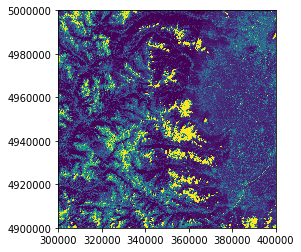

In [12]:
from rasterio.plot import show

# Plot band 1
show((raster, 1))

Here we can see that the `show` function created a map showing the pixel values of band 1.

Let's see how the different bands look like by placing them next to each other:

Text(0.5, 1.0, 'Blue')

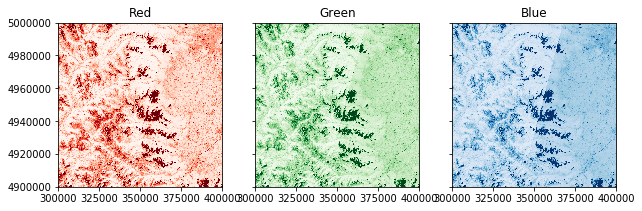

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

# Initialize subplots 
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(10, 4), sharey=True)

# Plot Red, Green and Blue (rgb)
show((raster, 1), cmap='Reds', ax=ax1)
show((raster, 2), cmap='Greens', ax=ax2)
show((raster, 3), cmap='Blues', ax=ax3)

# Add titles
ax1.set_title("Red")
ax2.set_title("Green")
ax3.set_title("Blue")


## RGB True color composite

Next let's see how we can plot these channels as a normal RGB image.

- First we need to read the bands into numpy arrays and normalize the cell values into scale ranging from 0.0 to 1.0:

In [14]:
# Read the grid values into numpy arrays
red = raster.read(1)
green = raster.read(2)
blue = raster.read(3)

# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

print("Normalized bands")
print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())

Normalized bands
0.0 - 1.0 mean: 0.22796277012637986
0.0 - 1.0 mean: 0.2944476011816232
0.0 - 1.0 mean: 0.3403491820073479


As the statistics show, now the arrays have been normalized into scale from 0 to 1. 

- Next we need to stack the values from different values together to produce the RGB true color composite. For this we can use Numpy's [dstack()](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.dstack.html) -function:

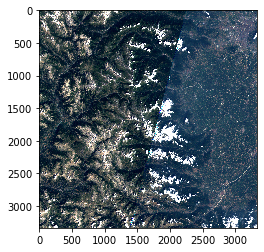

In [15]:
# Create RGB natural color composite
rgb = np.dstack((redn, greenn, bluen))

# Let's see how our color composite looks like
plt.imshow(rgb)

Here we go, now we have a typical RGB natural color composite image that looks like a photograph taken with the satellite. 

## False color composite

Following the previous example, it is easy to create false color composites with different band configurations. 

- One of the typical one, is to replace the blue band with near infra-red that can be used to detect vegetation easily where red color is emphasized. Let's use the same raster file as input, and generate our first false color composite:

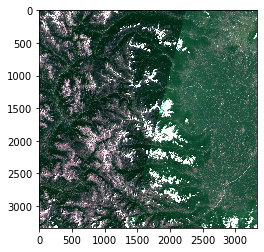

In [16]:
# Read the grid values into numpy arrays
nir = raster.read(1)
red = raster.read(3)
green = raster.read(2)

# Normalize the values using the function that we defined earlier
nirn = normalize(nir)
redn = normalize(red)
greenn = normalize(green)

# Create the composite by stacking
nrg = np.dstack((nirn, redn, greenn))

# Let's see how our color composite looks like
plt.imshow(nrg)

As we can see, now the vegetation can be seen more easily from the image (red color).

## Histogram of the raster data

Typically when working with raster data, you want to look at the histogram of different bands in your data. Luckily that is really easy to do with rasterio by using the `plot.show_hist()` function.


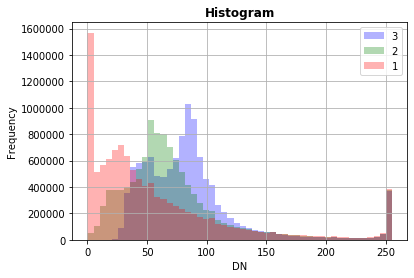

In [17]:
from rasterio.plot import show_hist
    
show_hist(raster, bins=50, lw=0.0, stacked=False, alpha=0.3,
      histtype='stepfilled', title="Histogram")

# Creating a raster mosaic

Quite often you need to merge multiple raster files together and create a `raster mosaic`. This can be done easily with the `merge()` -function in Rasterio.

Here, we will create a mosaic based on 2X2m resolution DEM files (altogether 12 files) covering the Helsinki Metropolitan region. If you have not downloaded the DEM files yet, you can do that by running the script from download-data -section of the tutorial.

As there are many `tif` files in our folder, it is not really pracical to start listing them manually. Luckily, we have a module and function called `glob` that can be used to create a list of those files that we are interested in based on search criteria.

Let's start by:
   
  - Importing required modules
  - Finding all `tif` files from the folder where the file starts with `L` -letter.


In [18]:
from rasterio.merge import merge
from rasterio.plot import show
import glob
import os
%matplotlib inline

# File and folder paths
dirpath = "data/raster/dsm_mosaic"
out_fp = "data/raster/DSM_Mosaic.tif"

# Make a search criteria to select the DEM files
search_criteria = "DSM_*.tif"
q = os.path.join(dirpath, search_criteria)
print(q)

data/raster/dsm_mosaic/DSM_*.tif


Now we can see that we have a search criteria (variable `q`) that we can pass to `glob` -function.

- List all digital elevation files with glob() -function:

In [19]:
# glob function can be used to list files from a directory with specific criteria
dem_fps = glob.glob(q)

# Files that were found:
dem_fps

['data/raster/dsm_mosaic/DSM_4.tif',
 'data/raster/dsm_mosaic/DSM_5.tif',
 'data/raster/dsm_mosaic/DSM_3.tif',
 'data/raster/dsm_mosaic/DSM_6.tif']

Great! Now we have all those 12 files in a list and we can start to make a mosaic out of them.

- Let's first create a list for the source raster datafiles (in read mode) with rasterio that will be used to create the mosaic:


In [20]:
# List for the source files
src_files_to_mosaic = []

# Iterate over raster files and add them to source -list in 'read mode'
for fp in dem_fps:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)

src_files_to_mosaic


[<open DatasetReader name='data/raster/dsm_mosaic/DSM_4.tif' mode='r'>,
 <open DatasetReader name='data/raster/dsm_mosaic/DSM_5.tif' mode='r'>,
 <open DatasetReader name='data/raster/dsm_mosaic/DSM_3.tif' mode='r'>,
 <open DatasetReader name='data/raster/dsm_mosaic/DSM_6.tif' mode='r'>]

As we can see, now the list contains all those files as raster objects in read mode (´mode='r'´).

- Let's plot a few of them next to each other to see how they look like:

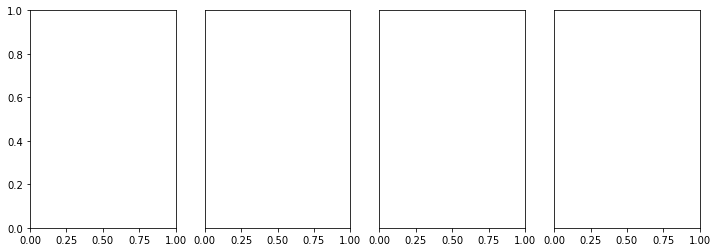

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

# Create 4 plots next to each other
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, figsize=(12, 4))

# Plot first four files
#show(src_files_to_mosaic[0], ax=ax1)
#show(src_files_to_mosaic[1], ax=ax2)
#show(src_files_to_mosaic[2], ax=ax3)
#show(src_files_to_mosaic[3], ax=ax4)

# Do not show y-ticks values in last three axis
for ax in [ax2, ax3, ax4]:
    ax.yaxis.set_visible(False)
    

As we can see we have multiple separate raster files that are actually located next to each other. Hence, we want to put them together into a single raster file that can by done by creating a raster mosaic.

- Now as we have placed the individual raster files in read -mode into the `source_files_to_mosaic` -list, it is really easy to merge those together and create a mosaic with rasterio's `merge` function:

In [22]:
# Merge function returns a single mosaic array and the transformation info
mosaic, out_trans = merge(src_files_to_mosaic)

# Plot the result
#show(mosaic, cmap='terrain')

RasterioIOError: Read or write failed. data/raster/dsm_mosaic/DSM_3.tif, band 1: IReadBlock failed at X offset 0, Y offset 1100: TIFFReadEncodedStrip() failed.

In [ ]:
print(out_trans)

Great, it looks correct! Now we are ready to save our mosaic to disk.

- Let's first update the metadata with our new dimensions, transform:

In [23]:
# Copy the metadata
out_meta = src.meta.copy()
for i in src_files_to_mosaic:
    print (i,i.meta)
# Update the metadata
out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans,
                 }
                )

<open DatasetReader name='data/raster/dsm_mosaic/DSM_4.tif' mode='r'> {'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999.0, 'width': 2624, 'height': 2220, 'count': 1, 'crs': CRS.from_dict(init='epsg:3003'), 'transform': Affine(0.5, 0.0, 1394991.0,
       0.0, -0.5, 4990394.0)}
<open DatasetReader name='data/raster/dsm_mosaic/DSM_5.tif' mode='r'> {'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999.0, 'width': 2624, 'height': 2220, 'count': 1, 'crs': CRS.from_dict(init='epsg:3003'), 'transform': Affine(0.5, 0.0, 1396303.0,
       0.0, -0.5, 4991504.0)}
<open DatasetReader name='data/raster/dsm_mosaic/DSM_3.tif' mode='r'> {'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999.0, 'width': 2624, 'height': 2220, 'count': 1, 'crs': CRS.from_dict(init='epsg:3003'), 'transform': Affine(0.5, 0.0, 1396303.0,
       0.0, -0.5, 4990394.0)}
<open DatasetReader name='data/raster/dsm_mosaic/DSM_6.tif' mode='r'> {'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999.0, 'width': 2624, 'height

NameError: name 'mosaic' is not defined

- Finally we can write our mosaic to our computer:

In [24]:
# Write the mosaic raster to disk
with rasterio.open(out_fp, "w", **out_meta) as dest:
    dest.write(mosaic)

NameError: name 'mosaic' is not defined

That's it! Easy!

# Masking / clipping raster

One common task in raster processing is to clip raster files based on a Polygon. The following example shows how to clip a the raster we have just merged.


- Import modules and specify the input and output filepaths

In [58]:
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import os
%matplotlib inline

# Input raster 
fp = os.path.join(data_dir, "DSM_Mosaic.tif")

# Output raster
out_tif = os.path.join(data_dir, "Sansa.tif")

- Let's start by opening the raster in read mode and visualizing it (using specific colormap called `terrain`):

In [59]:
# Read the data
data = rasterio.open(fp)
#show(data, cmap='terrain')

Okey, as you can see, we have the raster file where we can see a part of the city opf Turin. What we want to do next is to have the raster just for the area of San Salvario district and clip the raster based on that.


- Read th Shape file of turin district with GeoPandas

In [60]:
geo = gpd.read_file('data/turin_districts/turin_districts.shp')
geo

,ID_QUART,DENOM,geometry
0,1,Centro,"POLYGON ((1394747.520 4991457.426, 1394837.337..."
1,2,San Salvario,"POLYGON ((1395047.711 4988754.874, 1395057.312..."
2,3,Crocetta,"POLYGON ((1394090.953 4989975.136, 1394092.382..."
3,8,Vanchiglia,"POLYGON ((1396886.438 4992105.027, 1396909.184..."
4,7,Aurora,"POLYGON ((1395455.966 4992801.391, 1395512.196..."
5,22,Borgo Po e Cavoretto,"POLYGON ((1395548.456 4986023.979, 1395550.448..."
6,21,Madonna del Pilone,"POLYGON ((1398355.766 4991370.973, 1398373.463..."
7,6,San Donato,"POLYGON ((1393262.233 4992293.680, 1393273.505..."
8,5,Cenisia,"POLYGON ((1392858.499 4991547.149, 1392882.361..."
9,16,Madonna di Campagna,"POLYGON ((1393445.099 4995703.824, 1393447.591..."


In [61]:
geo=geo[geo.DENOM=='San Salvario']
geo

,ID_QUART,DENOM,geometry
1,2,San Salvario,"POLYGON ((1395047.711 4988754.874, 1395057.312..."


As we can see now we have a GeoDataFrame with Polygon inside. To be able to clip the raster with this Polygon, it is required that the data has identical coordinate reference system.

-  Re-project into the same coordinate system as the raster data. We can access the crs of the raster using attribute `.crs.data`:

In [62]:
print(data.crs.data)
print(geo.crs)

{'init': 'epsg:3003'}
{}


In [63]:
geo.crs={'init':'epsg:3003'}

In [64]:
# Project the Polygon into same CRS as the grid 
geo = geo.to_crs(crs=data.crs.data)

# Print crs
geo.crs

{'init': 'epsg:3003'}

- Next we need to get the coordinates of the geometry in such a format that rasterio wants them. This can be conducted easily with following function:

In [65]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

- Get the geometry coordinates by using the function.

/home/matteo/anaconda3/envs/gisenv/lib/python3.7/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/matteo/anaconda3/envs/gisenv/lib/python3.7/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/matteo/anaconda3/envs/gisenv/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/matteo/anaconda3/envs/gisenv/lib/python3.7/site-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/matteo/anaconda3/envs/gisenv/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


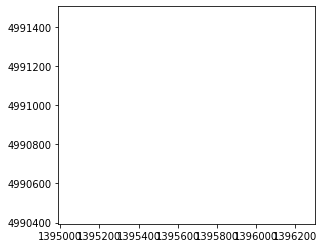

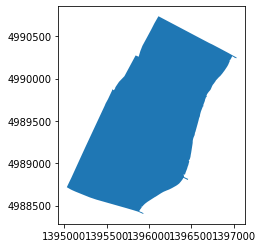

In [66]:
show(data)
geo.plot()

Okay, as we can see rasterio wants to have the coordinates of the Polygon in `GeoJSON` format.

- Now we are ready to clip the raster with the polygon using the `coords` variable that we just created. Clipping the raster can be done easily with the `mask` function that we imported in the beginning from `rasterio`, and specifying ``clip=True``.


In [34]:
# Clip the raster with Polygon
out_img, out_transform = mask(dataset=data, shapes=geo.geometry, crop=True)

- Next, we need to modify the metadata. Let's start by copying the metadata from the original data file.

In [35]:
# Copy the metadata
out_meta = data.meta.copy()
print(out_meta)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999.0, 'width': 2624, 'height': 2220, 'count': 1, 'crs': CRS.from_dict(init='epsg:3003'), 'transform': Affine(0.5, 0.0, 1394991.0,
       0.0, -0.5, 4991504.0)}


- Next we need to parse the EPSG value from the CRS so that we can create a `Proj4` -string using `PyCRS` library (to ensure that the projection information is saved correctly).

In [36]:
# Parse EPSG code
epsg_code = int(data.crs.data['init'][5:])
print(epsg_code)

3003


- Now we need to update the metadata with new dimensions, transform (affine) and CRS (as Proj4 text):

In [37]:
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform}
                         )

- Finally, we can save the clipped raster to disk with following command:

In [38]:
with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(out_img)

- Let's still check that the result is correct by plotting our new clipped raster.

In [39]:
# Open the clipped raster file
clipped = rasterio.open(out_tif)

# Visualize
#show(clipped, cmap='terrain')

Great, it worked! This is how you can easily clip (*mask*) raster files with rasterio.

## Reproject

In [40]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [41]:
out_tif_4326 = os.path.join(data_dir, "Sansa_4326.tif")
src=clipped
dst_crs = 'EPSG:4326'
transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
kwargs = src.meta.copy()
kwargs.update({
    'crs': dst_crs,
    'transform': transform,
    'width': width,
    'height': height
})

In [42]:
with rasterio.open(out_tif_4326, 'w', **kwargs) as dst:
    for i in range(1, src.count + 1):
        reproject(
            source=rasterio.band(src, i),
            destination=rasterio.band(dst, i),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest)

## Map Algebra

In [43]:
def slope_gradient(z):
    """
    Calculate absolute slope gradient elevation array.
    """
    x, y = np.gradient(z)  
    slope = np.sqrt(x*x + y*y)
    return slope

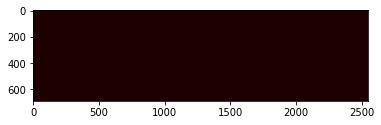

In [44]:
a=slope_gradient(clipped.read(1))
plt.imshow(a, vmin=0.0, vmax=1.0, cmap='pink')

In [45]:
def aspect(z):
    """Calculate aspect from DEM."""
    x, y = np.gradient(z)
    return np.arctan2(-x, y)

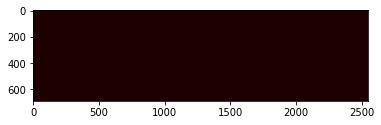

In [46]:
a=aspect(clipped.read(1))
plt.imshow(a, vmin=0.0, vmax=1.0, cmap='pink')

## GDAL DEMProcessing

In [25]:
import gdal
help(gdal.DEMProcessing)

Help on function DEMProcessing in module osgeo.gdal:

DEMProcessing(destName, srcDS, processing, **kwargs)
    Apply a DEM processing.
    Arguments are :
      destName --- Output dataset name
      srcDS --- a Dataset object or a filename
      processing --- one of "hillshade", "slope", "aspect", "color-relief", "TRI", "TPI", "Roughness"
    Keyword arguments are :
      options --- return of gdal.DEMProcessingOptions(), string or array of strings
      other keywords arguments of gdal.DEMProcessingOptions()
    If options is provided as a gdal.DEMProcessingOptions() object, other keywords are ignored.



Calculate slope for San Salvario District

In [26]:
gdal.DEMProcessing('data/raster/slope.tif', out_tif, 'slope')
slope=rasterio.open('data/raster/slope.tif')

NameError: name 'out_tif' is not defined

/home/matteo/anaconda3/envs/gisenv/lib/python3.7/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/matteo/anaconda3/envs/gisenv/lib/python3.7/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/matteo/anaconda3/envs/gisenv/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/matteo/anaconda3/envs/gisenv/lib/python3.7/site-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/matteo/anaconda3/envs/gisenv/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


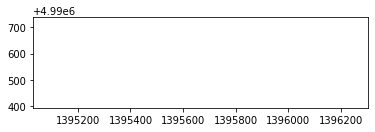

In [49]:
show(slope)

Calculate Aspect for San Salvario district

In [50]:
gdal.DEMProcessing('data/raster/aspect.tif', out_tif, 'aspect')
aspect=rasterio.open('data/raster/aspect.tif')

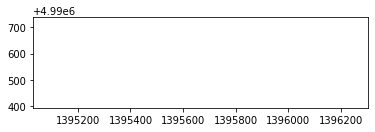

In [51]:
show(aspect)

Select suitable area for PV deployment:
    
    -filter slopes
    -filter aspect

In [52]:
suitable_slope=(slope.read(1)>15) & (slope.read(1)<36)

In [53]:
suitable_slope

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [54]:
suitable_aspect=(aspect.read(1)>240) & (aspect.read(1)<300)

Merge the two filters

In [55]:
suitable_area=suitable_slope & suitable_aspect

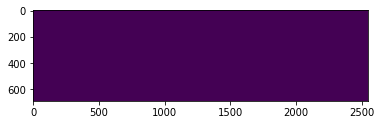

In [56]:
show(suitable_area)

In [ ]:
suitable_area=suitable_area.astype(int)
suitable_area

In [ ]:
mask = suitable_area != 0
results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            rasterio.features.shapes(suitable_area.astype('int16'),transform=clipped.transform, mask=mask)))

In [ ]:
geoms = list(results)
geoms

In [ ]:
suitable_area=gpd.read_file('data/suit_sansa.shp')

In [ ]:
import geopandas as gpd
suitarea  = gpd.GeoDataFrame.from_features(geoms)

In [ ]:
suitarea.crs=clipped.crs

In [ ]:
suitarea.crs

In [ ]:
suitarea=suitarea[suitarea.raster_val!=0]

In [ ]:
suitarea.to_crs(epsg='3003')

In [ ]:
#suitarea.plot()

In [ ]:
from rasterstats import gen_zonal_stats,zonal_stats

In [ ]:
help(gen_zonal_stats)

By default, the ``zonal_stats`` function will return the following statistics

- min
- max
- mean
- count

Optionally, these statistics are also available.

- sum
- std
- median
- majority
- minority
- unique
- range
- nodata
- percentile (see note below for details)

You can specify the statistics to calculate using the ``stats`` argument::

    >>> stats = zonal_stats("tests/data/polygons.shp",
    ...                     "tests/data/slope.tif",
    ...                     stats=['min', 'max', 'median', 'majority', 'sum'])


In [ ]:
# Read the raster values
array = slope.read(1)

# Get the affine
affine = clipped.transform

In [ ]:
array

In [70]:
from multiprocessing import Pool
import time
import multiprocessing as mp
mp.cpu_count()


12

In [71]:
polygonNumber=8000

In [77]:
starttime = time.time()
zonal_stats(suitarea, array, affine=affine, stats=['mean', 'count'],geojson_out=True)
print('That took {} seconds'.format(time.time() - starttime))

That took 56.037049770355225 seconds


In [72]:

#for index,row in suitarea.iterrows():
    #row
    #zonal_stats(row, array, affine=affine, stats=['mean', 'count'],geojson_out=True)
testRes=[]
starttime = time.time()
for x in range(polygonNumber):
    #print(type(suitarea.iloc[x]))
    #gpd.GeoDataFrame().set_geometry(suitarea.iloc[x]['geometry']).to_file(str(i)+'.shp')
    #gpd.GeoSeries(suitarea.iloc[x]['geometry']).to_file(str(x)+'.shp')
    testRes.append(zonal_stats(gpd.GeoSeries(suitarea.iloc[x]['geometry']), array, affine=affine, stats=['mean', 'count'],geojson_out=True))
print('That took {} seconds'.format(time.time() - starttime)) 

/home/matteo/anaconda3/envs/gisenv/lib/python3.7/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


That took 16.966639041900635 seconds


In [79]:
#testRes
len(suitarea)

88247

In [80]:
def processRaster(x):
    zonal_stats(x, array, affine=affine, stats=['mean', 'count'],geojson_out=True)


In [81]:
shpList=[gpd.GeoSeries(suitarea.iloc[x]['geometry']) for x in range(len(suitarea))]
starttime = time.time()
pool=Pool()
pool.map(processRaster,shpList)
pool.close()
print('That took {} seconds'.format(time.time() - starttime))


That took 33.05223083496094 seconds


In [152]:
test=gpd.read_file('0.shp')
test

,id,geometry
0,0,"POLYGON ((1396106.000 4990722.000, 1396106.500..."


In [ ]:
res=zonal_stats(suitarea, array, affine=affine, stats=['mean', 'count'],geojson_out=True)

In [ ]:
res

In [ ]:
suitable_area=gpd.GeoDataFrame.from_features(res)

In [ ]:
suitable_area.crs={'init':'epsg:3003'}
suitable_area.to_crs(epsg='4326')

In [ ]:
suitable_area['Area_real']=suitable_area['count']*(0.5*0.5)/np.cos(np.radians(suitable_area['mean']))

In [ ]:
suitable_area=suitable_area[suitable_area['Area_real']>5]

In [ ]:
suitable_area.to_file('data/suit_sansa.shp')

In [ ]:
import folium


In [ ]:
centroid=geo.to_crs(epsg='32632').centroid

In [ ]:
print(centroid[1].x,centroid[1].y)

In [ ]:
print(geo.centroid[1].x,geo.centroid[1].y)

In [ ]:
m = folium.Map([centroid.y, centroid.x],crs='EPSG4326', zoom_start=15, tiles="OpenStreetMap")

In [ ]:
folium.GeoJson(suitable_area.to_crs(epsg='4326').to_json(),name='suitable_area').add_to(m)
folium.raster_layers.WmsTileLayer(
    url='http://niger3.csi.it/mapproxy/service',
    name='ortofoto',
    fmt='image/png',
    layers='regp_agea_2015',
    transparent=True,
    overlay=True,
    control=True,
).add_to(m)

folium.LayerControl().add_to(m)
m